In [9]:
import numpy as np
import matplotlib.pyplot as plt
import math
import h5py

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # Tamaño de las gráficas
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%reload_ext autoreload
%autoreload 2

np.random.seed(1)

In [6]:
def load_data():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # Datos de entrada para entrenamiento
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # Datos de salida para entrenamiento

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) 
#Datos de entrada para test 
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) 
#Datos de salida para test

    classes = np.array(test_dataset["list_classes"][:]) # lista de clases
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
#Dataset

train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

# convertimos los datos al tamaño requerido 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # El "-1" significa convertir a una sola dimension las demás dimensiones
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Estandarizamos los valores (0,1).
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print('Train')
print(train_x.shape)
print(train_y.shape)
print('Test')
print(test_x.shape)
print(test_y.shape)

Train
(12288, 209)
(1, 209)
Test
(12288, 50)
(1, 50)


(209, 64, 64, 3)
y = 0. It's a non-cat picture.


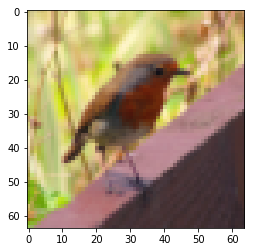

In [4]:
# Imagen de ejemplo
index = 10
print(train_x_orig.shape)
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

## Funciones de activación

In [6]:
σ = lambda Z: (1/(1 + np.exp(-Z)))
dσ = lambda Z: (σ(Z) * (1 - σ(Z)))
Relu = lambda Z: (np.maximum(0,Z))
#dRelu = lambda Z: ((Z > 0) * 1)
dRelu = lambda Z: (Z > 0)

## Propagación a capas siguientes

In [7]:
def forward_propagation(X, Weights, Dropout = 0):
    L = len(Weights)
    caches = []

    ##################
    Drops = []
    ##################
    
    A = X
    seed = 1
    for l in range(L-1):
        W,b = Weights[l]

        A_prev = A

        Z = np.dot(W, A_prev) + b
        A = Relu(Z)

        #######DROPUT########
        if Dropout > 0:
            np.random.seed(seed)
            Drop = np.random.randn(A.shape[0], A.shape[1]) < Dropout
            A = A * Drop
        #####################

        caches.append((A_prev, W, Z))

        ######################
        if Dropout > 0:
            Drops.append(Drop)
        ######################

        seed = seed + 1
        
    A_prev = A
    #Última capa
    W,b = Weights[L-1]

    Z = np.dot(W, A_prev) + b
    y_hat = σ(Z)

    caches.append((A_prev, W, Z))

    ###########devuelve Drops################
    return y_hat, caches, Drops

## Retropropagación

In [8]:
def backpropagation(y_hat, y, caches, Drops, Dropout = 0):
    ############Recibe Drops############
    L = len(caches)
    m = y_hat.shape[1]
    grads = []

    A_prev, W, Z = caches[L-1]
    #Última capa
    dy_hat = ( (1-y)/(1-y_hat) ) - ( y/y_hat )
    dZ = dy_hat * dσ(Z)
    dW = 1/m * np.dot(dZ, A_prev.T)
    db = 1/m * np.sum(dZ, axis=1, keepdims=True)
    dA = np.dot(W.T, dZ)

    grads.append((dW,db))

    for l in reversed(range(L-1)):
        A_prev, W, Z = caches[l]  

        ####################
        if Dropout > 0:
            dA = dA * Drops[l]
        ####################
  
        dZ = dA * dRelu(Z)
        dW = 1/m * np.dot(dZ, A_prev.T)
        db = 1/m * np.sum(dZ, axis=1, keepdims=True)
        dA = np.dot(W.T, dZ)

        grads.append((dW,db))

    grads = list(reversed(grads))
    return grads

## Inicialización de parámetros

In [9]:
def initialize(layer_dimensions):
    #layer_dimensions[0] es el tamaño de la capa de entrada
    np.random.seed(1)
    L = len(layer_dimensions)
    Weigths = []

    for l in range(1,L):
        W = np.random.randn(layer_dimensions[l],layer_dimensions[l-1]) / np.sqrt(layer_dimensions[l-1])
        b = np.zeros((layer_dimensions[l],1))

        Weigths.append((W,b))

    return Weigths

## Cross entropy loss

In [10]:
cross_entropy_loss = lambda y_hat, y: np.squeeze(( 1/y.shape[1] * (-np.dot(y,np.log(y_hat).T) - np.dot(1-y, np.log(1-y_hat).T)) ) )

## Método del gradiente clásico

In [11]:
def update(Weights, α, grads):
    L = len(Weights)

    for l in range(L):
        W,b = Weights[l]

        dW, db = grads[l]
        Weights[l] = W-α*dW, b-α*db

    return Weights

In [12]:
#Final L-layer model
def model(X,y, layer_dimensions, α, iters, print_cost = False, Dropout = 0):
    np.random.seed(1)
    costs = []
    m = X.shape[1]

    Weigts = initialize(layer_dimensions)

    for i in range(iters):
        
        ##############Drops############
        y_hat, caches, Drops = forward_propagation(X, Weigts, Dropout = Dropout)

        cost = cross_entropy_loss(y_hat, y)
        
        #############Drops############
        grads = backpropagation(y_hat, y, caches, Drops, Dropout= Dropout)
        
        Weigts = update(Weigts, α, grads)  

        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)

    costs = np.squeeze(costs)
    return Weigts, costs

## SGD

Stochastic Gradient Descent nos permite optimizar la red neuronal mucho más rápido haciendo actualizaciones a medio camino de una iteración sobre el data set.

In [13]:
def get_mini_batches(X, y, batch_size, seed):
    m = X.shape[1]
    #Cambiamos la semilla cada iteración
    np.random.seed(seed)
    
    #Se permutan de manera aleatoria todos los índices del 0 a m-1
    perm_index = list(np.random.permutation(m))
    #Permutamos las columnas en base a la distribución de índices obtenidos
    sX = X[:, perm_index]
    sy = y[:, perm_index]
    
    #Número de mini batches completos
    rnge = int(m/batch_size)

    minibatch = []
    for i in range(rnge):
        #Agarramos ese bloque de tamaño definido
        minibatch.append((sX[:,batch_size*i:batch_size*(i+1)], sy[:,batch_size*i:batch_size*(i+1)]))
        
        #Si estamos en la última pasada y aún sobran unos cuntos ejemplos, los agarramos como un mini batch aparte
        if(i+1 == rnge and m%batch_size != 0):
            minibatch.append((sX[:,batch_size*(i+1):sX.shape[1]], sy[:,batch_size*(i+1):sy.shape[1]]))

    return minibatch

In [14]:
def model_minibatches(X,y, layer_dimensions, α, iters, print_cost = False, Dropout = 0):
    np.random.seed(1)
    costs = []
    m = X.shape[1]

    Weights = initialize(layer_dimensions)

    seed = 10

    for i in range(iters):
        
        #mini batches
        seed = seed + 1
        
        minibatches = get_mini_batches(X, y, 90, seed)
        
        for minibatch in minibatches:
            
            minibatch_X, minibatch_Y = minibatch
            
            ##############Drops############
            y_hat, caches, Drops = forward_propagation(minibatch_X, Weights, Dropout=Dropout)
    
            cost = cross_entropy_loss(y_hat, minibatch_Y)
         
            ##############Drops############
            grads = backpropagation(y_hat, minibatch_Y, caches, Drops, Dropout=Dropout)

            Weights = update(Weights, α, grads)  

        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)

    costs = np.squeeze(costs)
    return Weights, costs

## Adam

Adam es uno de los métodos de optimización más efectivos para entrenar redes neuronales.

In [16]:
def model_adam(X, y, layer_dimensions, α, iters, β1=0.9, β2=0.999, ϵ=1e-8, print_cost = False, Dropout = 0):
    np.random.seed(1)
    costs = []
    m = X.shape[1]

    Weights = initialize(layer_dimensions)

    seed = 10
    
    #INICIALIZAR MOMENTOS
    L = len(Weights)
    mw,vw = [],[]
    mb,vb = [],[]
    for l in range(L):
        mw.append(np.zeros(Weights[l][0].shape))
        vw.append(np.zeros(Weights[l][0].shape))
        mb.append(np.zeros(Weights[l][1].shape))
        vb.append(np.zeros(Weights[l][1].shape))

    t = 0

    for i in range(iters):
        
        seed = seed + 1

        minibatches = get_mini_batches(X, y, 90, seed)

        for minibatch in minibatches:

            minibatch_X, minibatch_Y = minibatch

            y_hat, caches, Drops = forward_propagation(minibatch_X, Weights, Dropout = Dropout)

            cost = cross_entropy_loss(y_hat, minibatch_Y)

            grad = backpropagation(y_hat, minibatch_Y, caches, Drops, Dropout=Dropout)

            ##################ACTUALIZACIÓN DE PESOS##############
            t = t + 1
            for l in range(L):
                W, b = Weights[l]
                ΔW, Δb = grad[l]
                #Actualizando momentos
                mw[l] = β1*mw[l] + (1-β1)*ΔW
                vw[l] = β2*vw[l] + (1-β2)*(ΔW**2)

                mb[l] = β1*mb[l] + (1-β1)*Δb
                vb[l] = β2*vb[l] + (1-β2)*(Δb**2)
                
                #Corrección de sesgo
                mw_hat = mw[l]/(1-(β1**t))
                vw_hat = vw[l]/(1-(β2**t))
                
                mb_hat = mb[l]/(1-(β1**t))
                vb_hat = vb[l]/(1-(β2**t))

                #Actualización
                W = W - α*(mw_hat/(np.sqrt(vw_hat) + ϵ))
                b = b - α*(mb_hat/(np.sqrt(vb_hat) + ϵ))
                Weights[l] = (W,b)

        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
                
    costs = np.squeeze(costs)
    return Weights, costs

## Prueba del modelo

Cost after iteration 0: 0.637100
Cost after iteration 100: 0.068847
Cost after iteration 200: 0.012445
Cost after iteration 300: 0.004021
Cost after iteration 400: 0.000922
Cost after iteration 500: 0.000080
Cost after iteration 600: 0.000085
Cost after iteration 700: 0.000062
Cost after iteration 800: 0.000033
Cost after iteration 900: 0.000024
Cost after iteration 1000: 0.000012
Cost after iteration 1100: 0.000010
Cost after iteration 1200: 0.000010
Cost after iteration 1300: 0.000010
Cost after iteration 1400: 0.000004
Cost after iteration 1500: 0.000003
Cost after iteration 1600: 0.000002
Cost after iteration 1700: 0.000006
Cost after iteration 1800: 0.000006
Cost after iteration 1900: 0.000001
Cost after iteration 2000: 0.000002
Cost after iteration 2100: 0.000000
Cost after iteration 2200: 0.000001
Cost after iteration 2300: 0.000000
Cost after iteration 2400: 0.000001


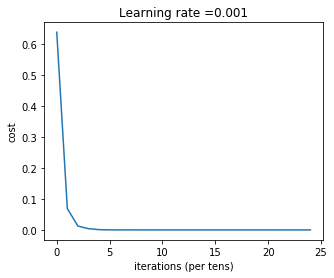

In [20]:
#layer_dimensions = [12288, 7, 1]
layer_dimensions = [12288, 100, 20, 1]
#α = 0.0075
α = 0.001
iters = 2500

Weights, costs = model_adam(train_x, train_y, layer_dimensions, α, iters, print_cost=True)

plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per tens)')
plt.title("Learning rate =" + str(α))
plt.show()

In [21]:
def check(X, y, Weigths):
    ##############
    preds, _, _ = forward_propagation(X, Weigths)
    preds = (preds > 0.5)*1

    pos = 0
    TP, TN, FP, FN = 0,0,0,0

    m = preds.shape[1]
    for i in range(m):
        if y[0][i] == preds[0][i]:
            if preds[0][i] == 1:
                TP += 1
            if preds[0][i] == 0:
                TN += 1
            pos += 1
        else:
            if preds[0][i] == 1:
                FP += 1
            if preds[0][i] == 0:
                FN += 1
    print(str(pos/m*100)+'% Accuracy')
    return TP, TN, FP, FN

In [22]:
print('Train')
check(train_x, train_y, Weights)
print('Test')
TP, TN, FP, FN = check(test_x, test_y, Weights)
print('Confusion matrix')
print(str(TP)+' ',str(FP)+'\n',str(FN)+' ',TN, sep = '')

Train
100.0% Accuracy
Test
76.0% Accuracy
Confusion matrix
25 4
8 13


In [25]:
import cv2
def predict(test, Weights, image=True):
    if image == True:
        orig = cv2.imread(test)
        orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)

        test = cv2.resize(cv2.imread(test), (64,64), interpolation = cv2.INTER_AREA)
        test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)

    #mostramos la imagen
    plt.imshow(orig)
    plt.plot()
    #Convertimos la imagen a un vector
    test =  np.reshape(test.flatten(), (12288,1)) / 255

    ##################
    pred, _, _ = forward_propagation(test, Weights)
    #print(pred)
    pred = pred > 0.5
    #print(pred)
    if pred == 1:
        print('Es un gato')
    else:
        print('No es un gato')

Es un gato


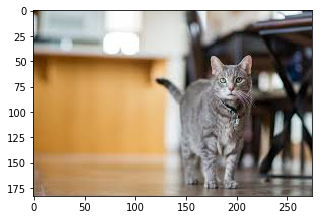

In [26]:
predict('test9.jpg', Weights)
#predict(train_x_orig[11,:,:,:], Weights, image=True)

## Implementación con librerías

In [27]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

Using TensorFlow backend.


In [28]:
keras_model = Sequential()
keras_model.add(Dense(100, input_dim = 12288, activation = 'relu'))
keras_model.add(Dense(20, activation = 'relu'))
keras_model.add(Dense(1, activation = 'sigmoid'))

In [29]:
keras_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
keras_model.fit(train_x.T, train_y.T, epochs=2500, batch_size=90)

Epoch 1/2500
209/209 [==============================] - 0s - loss: 1.2910 - acc: 0.5407     
Epoch 2/2500
209/209 [==============================] - 0s - loss: 2.9943 - acc: 0.4498     
Epoch 3/2500
209/209 [==============================] - 0s - loss: 2.2511 - acc: 0.6555     
Epoch 4/2500
209/209 [==============================] - 0s - loss: 1.5470 - acc: 0.5837     
Epoch 5/2500
209/209 [==============================] - 0s - loss: 0.9498 - acc: 0.5742     
Epoch 6/2500
209/209 [==============================] - ETA: 0s - loss: 1.5342 - acc: 0.633 - 0s - loss: 1.3738 - acc: 0.6603     
Epoch 7/2500
209/209 [==============================] - 0s - loss: 0.9365 - acc: 0.5072     
Epoch 8/2500
209/209 [==============================] - 0s - loss: 0.7758 - acc: 0.6699     
Epoch 9/2500
209/209 [==============================] - 0s - loss: 0.7130 - acc: 0.6077     
Epoch 10/2500
209/209 [==============================] - 0s - loss: 0.5589 - acc: 0.7177     
Epoch 11/2500
209/209 [========

209/209 [==============================] - 0s - loss: 0.0188 - acc: 1.0000     
Epoch 174/2500
209/209 [==============================] - 0s - loss: 0.0179 - acc: 1.0000     
Epoch 175/2500
209/209 [==============================] - 0s - loss: 0.0180 - acc: 1.0000     
Epoch 176/2500
209/209 [==============================] - 0s - loss: 0.0174 - acc: 1.0000     
Epoch 177/2500
209/209 [==============================] - 0s - loss: 0.0174 - acc: 1.0000     
Epoch 178/2500
209/209 [==============================] - 0s - loss: 0.0172 - acc: 1.0000     
Epoch 179/2500
209/209 [==============================] - 0s - loss: 0.0168 - acc: 1.0000     
Epoch 180/2500
209/209 [==============================] - 0s - loss: 0.0172 - acc: 1.0000     
Epoch 181/2500
209/209 [==============================] - 0s - loss: 0.0163 - acc: 1.0000     
Epoch 182/2500
209/209 [==============================] - 0s - loss: 0.0165 - acc: 1.0000     
Epoch 183/2500
209/209 [==============================] - 0s - lo

209/209 [==============================] - 0s - loss: 0.0033 - acc: 1.0000     
Epoch 346/2500
209/209 [==============================] - 0s - loss: 0.0031 - acc: 1.0000     
Epoch 347/2500
209/209 [==============================] - 0s - loss: 0.0034 - acc: 1.0000     
Epoch 348/2500
209/209 [==============================] - 0s - loss: 0.0032 - acc: 1.0000     
Epoch 349/2500
209/209 [==============================] - 0s - loss: 0.0032 - acc: 1.0000     
Epoch 350/2500
209/209 [==============================] - 0s - loss: 0.0032 - acc: 1.0000     
Epoch 351/2500
209/209 [==============================] - 0s - loss: 0.0030 - acc: 1.0000     
Epoch 352/2500
209/209 [==============================] - 0s - loss: 0.0030 - acc: 1.0000     
Epoch 353/2500
209/209 [==============================] - 0s - loss: 0.0030 - acc: 1.0000     
Epoch 354/2500
209/209 [==============================] - 0s - loss: 0.0030 - acc: 1.0000     
Epoch 355/2500
209/209 [==============================] - 0s - lo

209/209 [==============================] - 0s - loss: 0.0011 - acc: 1.0000     
Epoch 518/2500
209/209 [==============================] - 0s - loss: 0.0011 - acc: 1.0000        
Epoch 519/2500
209/209 [==============================] - 0s - loss: 0.0011 - acc: 1.0000     
Epoch 520/2500
209/209 [==============================] - 0s - loss: 0.0011 - acc: 1.0000     
Epoch 521/2500
209/209 [==============================] - 0s - loss: 0.0011 - acc: 1.0000     
Epoch 522/2500
209/209 [==============================] - 0s - loss: 0.0011 - acc: 1.0000     
Epoch 523/2500
209/209 [==============================] - 0s - loss: 0.0011 - acc: 1.0000         
Epoch 524/2500
209/209 [==============================] - 0s - loss: 0.0011 - acc: 1.0000        
Epoch 525/2500
209/209 [==============================] - 0s - loss: 0.0011 - acc: 1.0000     
Epoch 526/2500
209/209 [==============================] - 0s - loss: 0.0011 - acc: 1.0000     
Epoch 527/2500
209/209 [==============================]

209/209 [==============================] - 0s - loss: 5.1148e-04 - acc: 1.0000     
Epoch 683/2500
209/209 [==============================] - 0s - loss: 5.0934e-04 - acc: 1.0000     
Epoch 684/2500
209/209 [==============================] - 0s - loss: 5.1751e-04 - acc: 1.0000     
Epoch 685/2500
209/209 [==============================] - 0s - loss: 5.1057e-04 - acc: 1.0000     
Epoch 686/2500
209/209 [==============================] - 0s - loss: 5.0271e-04 - acc: 1.0000     
Epoch 687/2500
209/209 [==============================] - 0s - loss: 4.9901e-04 - acc: 1.0000     
Epoch 688/2500
209/209 [==============================] - 0s - loss: 4.9831e-04 - acc: 1.0000     
Epoch 689/2500
209/209 [==============================] - 0s - loss: 4.9419e-04 - acc: 1.0000     
Epoch 690/2500
209/209 [==============================] - 0s - loss: 4.9946e-04 - acc: 1.0000     
Epoch 691/2500
209/209 [==============================] - 0s - loss: 4.8776e-04 - acc: 1.0000     
Epoch 692/2500
209/209 [=

209/209 [==============================] - 0s - loss: 2.6837e-04 - acc: 1.0000     
Epoch 847/2500
209/209 [==============================] - 0s - loss: 2.6746e-04 - acc: 1.0000     
Epoch 848/2500
209/209 [==============================] - 0s - loss: 2.6715e-04 - acc: 1.0000     
Epoch 849/2500
209/209 [==============================] - 0s - loss: 2.6726e-04 - acc: 1.0000     
Epoch 850/2500
209/209 [==============================] - 0s - loss: 2.6513e-04 - acc: 1.0000     
Epoch 851/2500
209/209 [==============================] - 0s - loss: 2.6364e-04 - acc: 1.0000     
Epoch 852/2500
209/209 [==============================] - 0s - loss: 2.6328e-04 - acc: 1.0000     
Epoch 853/2500
209/209 [==============================] - 0s - loss: 2.6210e-04 - acc: 1.0000     
Epoch 854/2500
209/209 [==============================] - 0s - loss: 2.6067e-04 - acc: 1.0000     
Epoch 855/2500
209/209 [==============================] - 0s - loss: 2.5976e-04 - acc: 1.0000     
Epoch 856/2500
209/209 [=

209/209 [==============================] - 0s - loss: 1.5561e-04 - acc: 1.0000     
Epoch 1011/2500
209/209 [==============================] - 0s - loss: 1.5501e-04 - acc: 1.0000     
Epoch 1012/2500
209/209 [==============================] - 0s - loss: 1.5422e-04 - acc: 1.0000     
Epoch 1013/2500
209/209 [==============================] - 0s - loss: 1.5374e-04 - acc: 1.0000     
Epoch 1014/2500
209/209 [==============================] - 0s - loss: 1.5396e-04 - acc: 1.0000     
Epoch 1015/2500
209/209 [==============================] - 0s - loss: 1.5342e-04 - acc: 1.0000     
Epoch 1016/2500
209/209 [==============================] - 0s - loss: 1.5200e-04 - acc: 1.0000     
Epoch 1017/2500
209/209 [==============================] - 0s - loss: 1.5303e-04 - acc: 1.0000     
Epoch 1018/2500
209/209 [==============================] - 0s - loss: 1.5254e-04 - acc: 1.0000     
Epoch 1019/2500
209/209 [==============================] - 0s - loss: 1.5229e-04 - acc: 1.0000     
Epoch 1020/2500


209/209 [==============================] - 0s - loss: 1.2106e-04 - acc: 1.0000     
Epoch 1093/2500
209/209 [==============================] - 0s - loss: 1.2119e-04 - acc: 1.0000     
Epoch 1094/2500
209/209 [==============================] - 0s - loss: 1.1996e-04 - acc: 1.0000     
Epoch 1095/2500
209/209 [==============================] - 0s - loss: 1.2008e-04 - acc: 1.0000     
Epoch 1096/2500
209/209 [==============================] - 0s - loss: 1.1956e-04 - acc: 1.0000     
Epoch 1097/2500
209/209 [==============================] - 0s - loss: 1.1938e-04 - acc: 1.0000     
Epoch 1098/2500
209/209 [==============================] - 0s - loss: 1.1845e-04 - acc: 1.0000     
Epoch 1099/2500
209/209 [==============================] - 0s - loss: 1.1902e-04 - acc: 1.0000     
Epoch 1100/2500
209/209 [==============================] - 0s - loss: 1.1813e-04 - acc: 1.0000     
Epoch 1101/2500
209/209 [==============================] - 0s - loss: 1.1760e-04 - acc: 1.0000     
Epoch 1102/2500


209/209 [==============================] - 0s - loss: 9.5765e-05 - acc: 1.0000     
Epoch 1175/2500
209/209 [==============================] - 0s - loss: 9.5029e-05 - acc: 1.0000     
Epoch 1176/2500
209/209 [==============================] - 0s - loss: 9.4723e-05 - acc: 1.0000     
Epoch 1177/2500
209/209 [==============================] - 0s - loss: 9.4212e-05 - acc: 1.0000     
Epoch 1178/2500
209/209 [==============================] - 0s - loss: 9.4066e-05 - acc: 1.0000     
Epoch 1179/2500
209/209 [==============================] - 0s - loss: 9.4104e-05 - acc: 1.0000     
Epoch 1180/2500
209/209 [==============================] - 0s - loss: 9.3020e-05 - acc: 1.0000     
Epoch 1181/2500
209/209 [==============================] - 0s - loss: 9.2739e-05 - acc: 1.0000     
Epoch 1182/2500
209/209 [==============================] - 0s - loss: 9.2468e-05 - acc: 1.0000     
Epoch 1183/2500
209/209 [==============================] - 0s - loss: 9.2144e-05 - acc: 1.0000     
Epoch 1184/2500


209/209 [==============================] - 0s - loss: 7.4945e-05 - acc: 1.0000     
Epoch 1257/2500
209/209 [==============================] - 0s - loss: 7.4924e-05 - acc: 1.0000     
Epoch 1258/2500
209/209 [==============================] - 0s - loss: 7.4938e-05 - acc: 1.0000     
Epoch 1259/2500
209/209 [==============================] - 0s - loss: 7.4837e-05 - acc: 1.0000     
Epoch 1260/2500
209/209 [==============================] - 0s - loss: 7.4314e-05 - acc: 1.0000     
Epoch 1261/2500
209/209 [==============================] - 0s - loss: 7.3924e-05 - acc: 1.0000     
Epoch 1262/2500
209/209 [==============================] - 0s - loss: 7.4680e-05 - acc: 1.0000     
Epoch 1263/2500
209/209 [==============================] - 0s - loss: 7.4494e-05 - acc: 1.0000     
Epoch 1264/2500
209/209 [==============================] - 0s - loss: 7.3762e-05 - acc: 1.0000     
Epoch 1265/2500
209/209 [==============================] - 0s - loss: 7.3240e-05 - acc: 1.0000     
Epoch 1266/2500


209/209 [==============================] - 0s - loss: 6.0354e-05 - acc: 1.0000     
Epoch 1339/2500
209/209 [==============================] - 0s - loss: 6.0025e-05 - acc: 1.0000     
Epoch 1340/2500
209/209 [==============================] - 0s - loss: 6.0205e-05 - acc: 1.0000     
Epoch 1341/2500
209/209 [==============================] - 0s - loss: 6.0205e-05 - acc: 1.0000     
Epoch 1342/2500
209/209 [==============================] - 0s - loss: 6.0012e-05 - acc: 1.0000     
Epoch 1343/2500
209/209 [==============================] - 0s - loss: 5.9780e-05 - acc: 1.0000     
Epoch 1344/2500
209/209 [==============================] - 0s - loss: 5.9253e-05 - acc: 1.0000     
Epoch 1345/2500
209/209 [==============================] - 0s - loss: 5.9015e-05 - acc: 1.0000     
Epoch 1346/2500
209/209 [==============================] - 0s - loss: 5.8877e-05 - acc: 1.0000     
Epoch 1347/2500
209/209 [==============================] - 0s - loss: 5.8689e-05 - acc: 1.0000     
Epoch 1348/2500


209/209 [==============================] - 0s - loss: 4.9116e-05 - acc: 1.0000     
Epoch 1421/2500
209/209 [==============================] - 0s - loss: 4.9116e-05 - acc: 1.0000     
Epoch 1422/2500
209/209 [==============================] - 0s - loss: 4.8713e-05 - acc: 1.0000     
Epoch 1423/2500
209/209 [==============================] - 0s - loss: 4.8409e-05 - acc: 1.0000     
Epoch 1424/2500
209/209 [==============================] - 0s - loss: 4.8522e-05 - acc: 1.0000     
Epoch 1425/2500
209/209 [==============================] - 0s - loss: 4.8046e-05 - acc: 1.0000     
Epoch 1426/2500
209/209 [==============================] - 0s - loss: 4.7996e-05 - acc: 1.0000     
Epoch 1427/2500
209/209 [==============================] - 0s - loss: 4.7808e-05 - acc: 1.0000     
Epoch 1428/2500
209/209 [==============================] - 0s - loss: 4.7700e-05 - acc: 1.0000     
Epoch 1429/2500
209/209 [==============================] - 0s - loss: 4.7529e-05 - acc: 1.0000     
Epoch 1430/2500


209/209 [==============================] - 0s - loss: 3.9671e-05 - acc: 1.0000     
Epoch 1503/2500
209/209 [==============================] - 0s - loss: 3.9577e-05 - acc: 1.0000     
Epoch 1504/2500
209/209 [==============================] - 0s - loss: 3.9471e-05 - acc: 1.0000     
Epoch 1505/2500
209/209 [==============================] - 0s - loss: 3.9550e-05 - acc: 1.0000     
Epoch 1506/2500
209/209 [==============================] - 0s - loss: 3.9239e-05 - acc: 1.0000     
Epoch 1507/2500
209/209 [==============================] - 0s - loss: 3.9199e-05 - acc: 1.0000     
Epoch 1508/2500
209/209 [==============================] - 0s - loss: 3.9142e-05 - acc: 1.0000     
Epoch 1509/2500
209/209 [==============================] - 0s - loss: 3.9040e-05 - acc: 1.0000     
Epoch 1510/2500
209/209 [==============================] - 0s - loss: 3.8931e-05 - acc: 1.0000     
Epoch 1511/2500
209/209 [==============================] - 0s - loss: 3.8862e-05 - acc: 1.0000     
Epoch 1512/2500


209/209 [==============================] - 0s - loss: 2.6993e-05 - acc: 1.0000     
Epoch 1666/2500
209/209 [==============================] - 0s - loss: 2.6823e-05 - acc: 1.0000     
Epoch 1667/2500
209/209 [==============================] - 0s - loss: 2.6790e-05 - acc: 1.0000     
Epoch 1668/2500
209/209 [==============================] - 0s - loss: 2.6740e-05 - acc: 1.0000     
Epoch 1669/2500
209/209 [==============================] - 0s - loss: 2.6695e-05 - acc: 1.0000     
Epoch 1670/2500
209/209 [==============================] - 0s - loss: 2.6608e-05 - acc: 1.0000     
Epoch 1671/2500
209/209 [==============================] - 0s - loss: 2.6595e-05 - acc: 1.0000     
Epoch 1672/2500
209/209 [==============================] - 0s - loss: 2.6564e-05 - acc: 1.0000     
Epoch 1673/2500
209/209 [==============================] - 0s - loss: 2.6711e-05 - acc: 1.0000     
Epoch 1674/2500
209/209 [==============================] - 0s - loss: 2.6605e-05 - acc: 1.0000     
Epoch 1675/2500


209/209 [==============================] - 0s - loss: 2.2267e-05 - acc: 1.0000     
Epoch 1748/2500
209/209 [==============================] - 0s - loss: 2.2200e-05 - acc: 1.0000     
Epoch 1749/2500
209/209 [==============================] - 0s - loss: 2.2165e-05 - acc: 1.0000     
Epoch 1750/2500
209/209 [==============================] - 0s - loss: 2.2103e-05 - acc: 1.0000     
Epoch 1751/2500
209/209 [==============================] - 0s - loss: 2.2033e-05 - acc: 1.0000     
Epoch 1752/2500
209/209 [==============================] - 0s - loss: 2.2006e-05 - acc: 1.0000     
Epoch 1753/2500
209/209 [==============================] - 0s - loss: 2.2064e-05 - acc: 1.0000     
Epoch 1754/2500
209/209 [==============================] - 0s - loss: 2.1988e-05 - acc: 1.0000     
Epoch 1755/2500
209/209 [==============================] - 0s - loss: 2.1925e-05 - acc: 1.0000     
Epoch 1756/2500
209/209 [==============================] - 0s - loss: 2.1830e-05 - acc: 1.0000     
Epoch 1757/2500


209/209 [==============================] - 0s - loss: 1.8510e-05 - acc: 1.0000     
Epoch 1830/2500
209/209 [==============================] - 0s - loss: 1.8449e-05 - acc: 1.0000     
Epoch 1831/2500
209/209 [==============================] - 0s - loss: 1.8583e-05 - acc: 1.0000     
Epoch 1832/2500
209/209 [==============================] - 0s - loss: 1.8641e-05 - acc: 1.0000     
Epoch 1833/2500
209/209 [==============================] - 0s - loss: 1.8572e-05 - acc: 1.0000     
Epoch 1834/2500
209/209 [==============================] - 0s - loss: 1.8513e-05 - acc: 1.0000     
Epoch 1835/2500
209/209 [==============================] - 0s - loss: 1.8352e-05 - acc: 1.0000     
Epoch 1836/2500
209/209 [==============================] - 0s - loss: 1.8258e-05 - acc: 1.0000     
Epoch 1837/2500
209/209 [==============================] - 0s - loss: 1.8192e-05 - acc: 1.0000     
Epoch 1838/2500
209/209 [==============================] - 0s - loss: 1.8181e-05 - acc: 1.0000     
Epoch 1839/2500


209/209 [==============================] - 0s - loss: 1.3106e-05 - acc: 1.0000     
Epoch 1993/2500
209/209 [==============================] - 0s - loss: 1.3051e-05 - acc: 1.0000     
Epoch 1994/2500
209/209 [==============================] - 0s - loss: 1.2965e-05 - acc: 1.0000     
Epoch 1995/2500
209/209 [==============================] - 0s - loss: 1.2933e-05 - acc: 1.0000     
Epoch 1996/2500
209/209 [==============================] - 0s - loss: 1.2917e-05 - acc: 1.0000     
Epoch 1997/2500
209/209 [==============================] - 0s - loss: 1.2917e-05 - acc: 1.0000     
Epoch 1998/2500
209/209 [==============================] - 0s - loss: 1.2917e-05 - acc: 1.0000     
Epoch 1999/2500
209/209 [==============================] - 0s - loss: 1.2825e-05 - acc: 1.0000     
Epoch 2000/2500
209/209 [==============================] - 0s - loss: 1.2807e-05 - acc: 1.0000     
Epoch 2001/2500
209/209 [==============================] - 0s - loss: 1.2793e-05 - acc: 1.0000     
Epoch 2002/2500


209/209 [==============================] - 0s - loss: 1.0982e-05 - acc: 1.0000     
Epoch 2075/2500
209/209 [==============================] - 0s - loss: 1.0944e-05 - acc: 1.0000     
Epoch 2076/2500
209/209 [==============================] - 0s - loss: 1.0922e-05 - acc: 1.0000     
Epoch 2077/2500
209/209 [==============================] - 0s - loss: 1.0875e-05 - acc: 1.0000     
Epoch 2078/2500
209/209 [==============================] - 0s - loss: 1.0898e-05 - acc: 1.0000     
Epoch 2079/2500
209/209 [==============================] - 0s - loss: 1.0908e-05 - acc: 1.0000     
Epoch 2080/2500
209/209 [==============================] - 0s - loss: 1.0868e-05 - acc: 1.0000     
Epoch 2081/2500
209/209 [==============================] - 0s - loss: 1.0804e-05 - acc: 1.0000     
Epoch 2082/2500
209/209 [==============================] - 0s - loss: 1.0791e-05 - acc: 1.0000     
Epoch 2083/2500
209/209 [==============================] - 0s - loss: 1.0768e-05 - acc: 1.0000     
Epoch 2084/2500


209/209 [==============================] - 0s - loss: 9.2473e-06 - acc: 1.0000     
Epoch 2157/2500
209/209 [==============================] - 0s - loss: 9.2221e-06 - acc: 1.0000     
Epoch 2158/2500
209/209 [==============================] - 0s - loss: 9.1930e-06 - acc: 1.0000     
Epoch 2159/2500
209/209 [==============================] - 0s - loss: 9.1747e-06 - acc: 1.0000     
Epoch 2160/2500
209/209 [==============================] - 0s - loss: 9.1649e-06 - acc: 1.0000     
Epoch 2161/2500
209/209 [==============================] - 0s - loss: 9.1468e-06 - acc: 1.0000     
Epoch 2162/2500
209/209 [==============================] - 0s - loss: 9.1252e-06 - acc: 1.0000     
Epoch 2163/2500
209/209 [==============================] - 0s - loss: 9.1071e-06 - acc: 1.0000     
Epoch 2164/2500
209/209 [==============================] - 0s - loss: 9.0956e-06 - acc: 1.0000     
Epoch 2165/2500
209/209 [==============================] - 0s - loss: 9.0678e-06 - acc: 1.0000     
Epoch 2166/2500


209/209 [==============================] - 0s - loss: 7.7414e-06 - acc: 1.0000     
Epoch 2239/2500
209/209 [==============================] - 0s - loss: 7.7540e-06 - acc: 1.0000     
Epoch 2240/2500
209/209 [==============================] - 0s - loss: 7.7345e-06 - acc: 1.0000     
Epoch 2241/2500
209/209 [==============================] - 0s - loss: 7.6942e-06 - acc: 1.0000     
Epoch 2242/2500
209/209 [==============================] - 0s - loss: 7.6427e-06 - acc: 1.0000     
Epoch 2243/2500
209/209 [==============================] - 0s - loss: 7.6013e-06 - acc: 1.0000     
Epoch 2244/2500
209/209 [==============================] - 0s - loss: 7.6602e-06 - acc: 1.0000     
Epoch 2245/2500
209/209 [==============================] - 0s - loss: 7.5941e-06 - acc: 1.0000     
Epoch 2246/2500
209/209 [==============================] - 0s - loss: 7.5969e-06 - acc: 1.0000     
Epoch 2247/2500
209/209 [==============================] - 0s - loss: 7.5795e-06 - acc: 1.0000     
Epoch 2248/2500


209/209 [==============================] - 0s - loss: 5.2143e-06 - acc: 1.0000     
Epoch 2402/2500
209/209 [==============================] - 0s - loss: 5.2105e-06 - acc: 1.0000     
Epoch 2403/2500
209/209 [==============================] - 0s - loss: 5.2285e-06 - acc: 1.0000     
Epoch 2404/2500
209/209 [==============================] - 0s - loss: 5.2076e-06 - acc: 1.0000     
Epoch 2405/2500
209/209 [==============================] - 0s - loss: 5.1913e-06 - acc: 1.0000     
Epoch 2406/2500
209/209 [==============================] - 0s - loss: 5.1433e-06 - acc: 1.0000     
Epoch 2407/2500
209/209 [==============================] - 0s - loss: 5.1568e-06 - acc: 1.0000     
Epoch 2408/2500
209/209 [==============================] - 0s - loss: 5.1925e-06 - acc: 1.0000     
Epoch 2409/2500
209/209 [==============================] - 0s - loss: 5.2077e-06 - acc: 1.0000     
Epoch 2410/2500
209/209 [==============================] - 0s - loss: 5.1886e-06 - acc: 1.0000     
Epoch 2411/2500


209/209 [==============================] - 0s - loss: 4.3381e-06 - acc: 1.0000     
Epoch 2484/2500
209/209 [==============================] - 0s - loss: 4.3324e-06 - acc: 1.0000     
Epoch 2485/2500
209/209 [==============================] - 0s - loss: 4.3181e-06 - acc: 1.0000     
Epoch 2486/2500
209/209 [==============================] - 0s - loss: 4.3123e-06 - acc: 1.0000     
Epoch 2487/2500
209/209 [==============================] - 0s - loss: 4.3012e-06 - acc: 1.0000     
Epoch 2488/2500
209/209 [==============================] - 0s - loss: 4.2872e-06 - acc: 1.0000     
Epoch 2489/2500
209/209 [==============================] - 0s - loss: 4.2811e-06 - acc: 1.0000     
Epoch 2490/2500
209/209 [==============================] - 0s - loss: 4.3151e-06 - acc: 1.0000     
Epoch 2491/2500
209/209 [==============================] - 0s - loss: 4.3297e-06 - acc: 1.0000     
Epoch 2492/2500
209/209 [==============================] - 0s - loss: 4.3113e-06 - acc: 1.0000     
Epoch 2493/2500


In [7]:
scores = keras_model.evaluate(test_x.T, test_y.T)
print('\n' + keras_model.metrics_names[1], scores[1]*100, '%')

NameError: name 'keras_model' is not defined

Es un gato


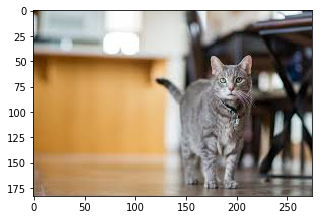

In [33]:
img = 'test9.jpg'

orig = cv2.imread(img)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)

plt.imshow(orig)
plt.plot()

test = cv2.resize(cv2.imread(img), (64,64), interpolation = cv2.INTER_AREA)
test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
test =  np.reshape(test.flatten(), (12288,1)) / 255

pred = keras_model.predict(test.T)
if np.squeeze(pred) > 0.5:
    print('Es un gato')
else:
    print('No es un gato')